## 4.0  Analysis of Bureau Dataset

> In this notebook I analyze the `bureau` dataset which is described below:
> - Client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
> - For every loan there are as many rows as number of credits the client had in Credit Bureau before the application date.

#### Analysis Summary:
> After analyzing the `bureau` dataset I created a vector for each loan id with following columns:
>> - __COUNT_GROUP__: The number of accounts by bin size of 5( i.e. 1 means 0 to 5 accounts).
>> - __OVERDUE__: Flag to indicate if a client has an overdue account.
>> - __DEBT_OVER_50%__: Account group with credit limit 50% or higher.
>> - __DEBT_OVER_75%__: Account group with credit limit higher 75% or higher.
>> - __DEBT_OVER_100%__: Account group with credit limit higher 100% or higher.
>> - __ACTIVE__: The number of active accounts by id group by bin size of 5. 
>> - __CLOSED__: The number of closed accounts by id group by bin size of 5. 
>> - __ADVERSE__: The number of adverse (bad debt or sold) accounts by id group by bin size of 5. 
>> - __CREDIT_TYPE_COUNT__: The number of different types accounts by id group. 

> I also created an aggregate table of four functions ('minimum', 'maximum', 'mean','standard deviation') `SK_ID_CURR` for each of the availble `float64` fields.  Each field would have a new column for each of the functions.  This created a total of 48 features.  By taking this approach I figure there will be many fields available during model selection that can be removed if there feature importance is zero.


In [81]:
#import helper ultility module
%load_ext autoreload
%aimport utils
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)

import math
from scipy import stats
import numpy as np

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 4.1 Import Datasets And Prepare ABT
> - Import the train and test datasets combined using a utility helper 
> - Create Activity Base Table (ABT) to group the fields by type.

In [83]:
dataset =  utils.get_bureau()

In [84]:
dataset.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497.00,0.00,-153.00,-153.00,nan,0.00,"91,323.00",0.00,nan,0.00,Consumer credit,-131.00,nan
1,215354,5714463,Active,currency 1,-208.00,0.00,"1,075.00",nan,nan,0.00,"225,000.00","171,342.00",nan,0.00,Credit card,-20.00,nan
2,215354,5714464,Active,currency 1,-203.00,0.00,528.00,nan,nan,0.00,"464,323.50",nan,nan,0.00,Consumer credit,-16.00,nan
3,215354,5714465,Active,currency 1,-203.00,0.00,nan,nan,nan,0.00,"90,000.00",nan,nan,0.00,Credit card,-16.00,nan
4,215354,5714466,Active,currency 1,-629.00,0.00,"1,197.00",nan,"77,674.50",0.00,"2,700,000.00",nan,nan,0.00,Consumer credit,-21.00,nan


In [85]:
abt = utils.ABT(dataset)

In [86]:
float_table = abt.float_table
print("Total float64 types: {}".format(len(float_table)))
float_table 

Total float64 types: 12


,num,count,na_count,na_%,mean,std,min,25%,50%,75%,max
DAYS_CREDIT,1,"1,716,428.00",0.00,0.00,"-1,142.11",795.16,"-2,922.00","-1,666.00",-987.00,-474.00,0.00
CREDIT_DAY_OVERDUE,2,"1,716,428.00",0.00,0.00,0.82,36.54,0.00,0.00,0.00,0.00,"2,792.00"
DAYS_CREDIT_ENDDATE,3,"1,610,875.00","105,553.00",0.06,510.52,"4,994.22","-42,060.00","-1,138.00",-330.00,474.00,"31,199.00"
DAYS_ENDDATE_FACT,4,"1,082,775.00","633,653.00",0.37,"-1,017.44",714.01,"-42,023.00","-1,489.00",-897.00,-425.00,0.00
AMT_CREDIT_MAX_OVERDUE,5,"591,940.00","1,124,488.00",0.66,"3,825.42","206,031.61",0.00,0.00,0.00,0.00,"115,987,185.00"
CNT_CREDIT_PROLONG,6,"1,716,428.00",0.00,0.00,0.01,0.10,0.00,0.00,0.00,0.00,9.00
AMT_CREDIT_SUM,7,"1,716,415.00",13.00,0.00,"354,994.59","1,149,811.34",0.00,"51,300.00","125,518.50","315,000.00","585,000,000.00"
AMT_CREDIT_SUM_DEBT,8,"1,458,759.00","257,669.00",0.15,"137,085.12","677,401.13","-4,705,600.32",0.00,0.00,"40,153.50","170,100,000.00"
AMT_CREDIT_SUM_LIMIT,9,"1,124,648.00","591,780.00",0.34,"6,229.51","45,032.03","-586,406.11",0.00,0.00,0.00,"4,705,600.32"
AMT_CREDIT_SUM_OVERDUE,10,"1,716,428.00",0.00,0.00,37.91,"5,937.65",0.00,0.00,0.00,0.00,"3,756,681.00"


In [87]:
# print description of each field in the integer ABT
field_table = utils.FieldsNames()
field_table.print('bureau.csv',float_table.index.values.tolist()) 

1) ['DAYS_CREDIT']: How many days before current application did client apply for Credit Bureau credit
----------------------------------------
2) ['CREDIT_DAY_OVERDUE']: Number of days past due on CB credit at the time of application for related loan in our sample
----------------------------------------
3) ['DAYS_CREDIT_ENDDATE']: Remaining duration of CB credit (in days) at the time of application in Home Credit
----------------------------------------
4) ['DAYS_ENDDATE_FACT']: Days since CB credit ended at the time of application in Home Credit (only for closed credit)
----------------------------------------
5) ['AMT_CREDIT_MAX_OVERDUE']: Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)
----------------------------------------
6) ['CNT_CREDIT_PROLONG']: How many times was the Credit Bureau credit prolonged
----------------------------------------
7) ['AMT_CREDIT_SUM']: Current credit amount for the Credit Bureau credit
---------

In [88]:
#exclude the ['SK_ID_CURR','TARGET','DATASET'] fields from the ABT
other_table = abt.other_table
print("Total string types: {}".format(len(other_table)))
other_table 

Total string types: 3


,num,count,na_count,na_%,unique,top,top_count,top_%
column,,,,,,,,
CREDIT_ACTIVE,1,1716428,0,0.00,4,Closed,1079273,0.63
CREDIT_CURRENCY,2,1716428,0,0.00,4,currency 1,1715020,1.00
CREDIT_TYPE,3,1716428,0,0.00,15,Consumer credit,1251615,0.73


In [89]:
# print description of each field in the string ABT
field_table = utils.FieldsNames()
field_table.print('bureau.csv',other_table.index.values.tolist()) 

1) ['CREDIT_ACTIVE']: Status of the Credit Bureau (CB) reported credits
----------------------------------------
2) ['CREDIT_CURRENCY']: Recoded currency of the Credit Bureau credit
----------------------------------------
3) ['CREDIT_TYPE']: Type of Credit Bureau credit (Car, cash,...)
----------------------------------------


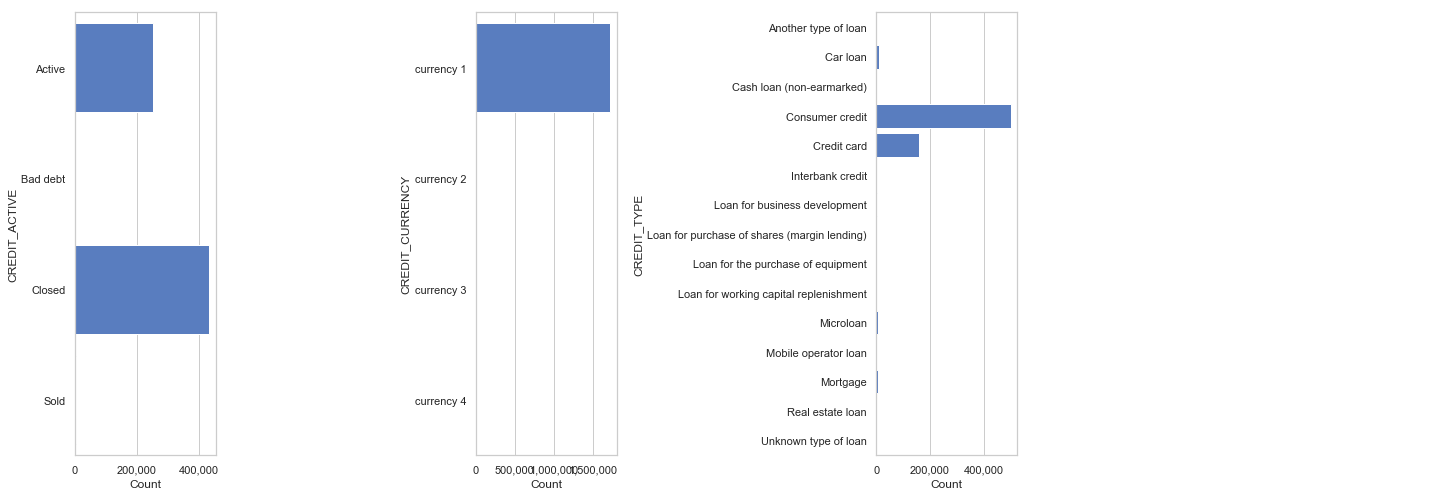

In [90]:
utils.plot_hbar(other_table.index,dataset)

### 4.2 Add `CREDIT_ACTIVE` Columns 
> - Lets create a table that counts the number of `CREDIT_ACTIVE` by `SK_ID_CURR`.
> - We can combined this table with others to create a final features table.

In [91]:
credit_active_table = pd.pivot_table(dataset,index =['SK_ID_CURR'], 
                     columns=['CREDIT_ACTIVE'],
                     values=['DAYS_CREDIT'],aggfunc='count',fill_value=0)

#let replace columns with no spaces and make upper case
cols = [c.replace(' ','_').upper() for c in credit_active_table.columns.levels[1]]
credit_active_table.columns = cols

#lets column to cobined bad debt and sold
credit_active_table.head()

,ACTIVE,BAD_DEBT,CLOSED,SOLD
SK_ID_CURR,,,,
100001,3,0,4,0
100002,2,0,6,0
100003,1,0,3,0
100004,0,0,2,0
100005,2,0,1,0


In [92]:
def make_cat(feature,df):
    """ Lets reduce the number of counts
        by grouping them into bins of 5 and setting a ceiling value.
    """ 
    df[feature]  = df[feature].apply(lambda x:int(x/5)+1)
    utils.applyMax([feature],df)  

In [93]:
#lets 'ACTIVE' into a category in bins size 5
make_cat('ACTIVE',credit_active_table)
credit_active_table.groupby(['ACTIVE']) .size()

ACTIVE
1    276932
2     28879
dtype: int64

In [94]:
#lets 'CLOSED' into a category in bins size 5
make_cat('CLOSED',credit_active_table)
credit_active_table.groupby(['CLOSED']) .size()

CLOSED
1    218588
2     68564
3     14621
4      4038
dtype: int64

In [95]:
#lets combine 'BAD_DEBT' and 'SOLD' into one field called 'ADVERSE' since 
# by themselves they are too unbalance.
def adverse(x):
    bad = x['BAD_DEBT'] > 0
    sold = x['SOLD'] > 0
    if bad or sold:
        return 2
    else:
        return 1
    
credit_active_table['ADVERSE'] = credit_active_table.apply(adverse,axis=1).astype('int64')
credit_active_table.groupby(['ADVERSE']) .size()

ADVERSE
1    299772
2      6039
dtype: int64

In [96]:
#lets drop columns
credit_active_table.drop(['BAD_DEBT', 'SOLD'], axis=1, inplace=True)

In [97]:
#resent index
credit_active_table.reset_index(inplace=True)
credit_active_table.head()

,SK_ID_CURR,ACTIVE,CLOSED,ADVERSE
0,100001,1,1,1
1,100002,1,2,1
2,100003,1,1,1
3,100004,1,1,1
4,100005,1,1,1


### 4.3 Add Count Field
> Count the number of bureau records by loan id and then create a category count group of bin size 5.

In [98]:
dataset['COUNT'] = dataset.groupby('SK_ID_CURR')['SK_ID_CURR'].transform('count')
dataset['COUNT_GROUP'] = dataset['COUNT'].apply(lambda x:int(x/5)+1)
dataset.drop('COUNT',axis=1,inplace=True)
dataset.groupby('COUNT_GROUP').size()

COUNT_GROUP
1     370880
2     682749
3     401642
4     166453
5      60091
6      20791
7       7337
8       2976
9       1241
10       890
11       519
12       450
13       121
16        78
19        94
24       116
dtype: int64

### 4.4 Add Count Orverdue Counts
> - Create new coulumn to count the number of accounts
that are overdue.

In [99]:
def overDue(df):
    name_flag = 'OVERDUE_FLAG'
    name = 'OVERDUE'
    
    def fun(x):
        days = abs(x)
        if days > 0:
            return 1
        else:
            return 0

    df[name_flag] = df['CREDIT_DAY_OVERDUE'].apply(fun)
    
    df[name] = df.groupby('SK_ID_CURR')[name_flag].transform('sum')
    
    #lets increase the groups by 1 to make the base group 1
    df[name] = df[name].apply(lambda x:x+1)
    
    #drop column
    df.drop([name_flag],axis=1, inplace=True)

#apply function
overDue(dataset)

In [100]:
dataset.groupby(['OVERDUE']).size()

OVERDUE
1    1686759
2      26998
3       1893
4        441
5        153
6        104
7         62
8         18
dtype: int64

### 4.5 Add Count Credit Type Count
> - Create new column to count the number of different account credit types.

In [101]:
#groupby id and credit types
credit_size = dataset.groupby(['SK_ID_CURR','CREDIT_TYPE']).size()

#create new dataframe
df_credit_size = pd.DataFrame(data=credit_size.values,
                              index=credit_size.index,columns=['COUNT'])

df_credit_size.reset_index(inplace=True)

credit_type_size = df_credit_size.groupby('SK_ID_CURR').size() 

credit_type_count = pd.DataFrame(data=credit_type_size.values,
                              index=credit_type_size.index,
                                 columns=['CREDIT_TYPE_COUNT'])
credit_type_count.reset_index(inplace=True)
credit_type_count.head()

,SK_ID_CURR,CREDIT_TYPE_COUNT
0,100001,1
1,100002,2
2,100003,2
3,100004,1
4,100005,2


In [102]:
credit_type_count.groupby('CREDIT_TYPE_COUNT').size().head()

CREDIT_TYPE_COUNT
1    109315
2    166653
3     27652
4      2113
5        74
dtype: int64

### 4.6 Add Count High Debt Accounts
>  Create two new columns to count the number of high debt accounts:
>> - Accounts with used debt limit of 50% or higher.
>> - Accounts with used debt limit of 100% or higher.

In [103]:
#fill nan values
dataset[['AMT_CREDIT_SUM_DEBT']]= dataset[['AMT_CREDIT_SUM_DEBT']].fillna(0)
dataset[['AMT_CREDIT_SUM']]= dataset[['AMT_CREDIT_SUM']].fillna(0)

In [104]:
def debtPercent(x):
    '''Calculate debt percent.'''
    debt = x['AMT_CREDIT_SUM_DEBT']
    limit = x['AMT_CREDIT_SUM']
    if debt <= 0 :
        return 0
    elif limit <=0:
        return 0
    else:
        return debt/limit
    
#apply function
dataset['DEBT_PERCENT'] = dataset.apply(debtPercent,axis=1)

In [105]:
def highDebt(name,df,threshold):
    name_flag = 'HIGH_DEBT_FLAG'

    df[name_flag] = df['DEBT_PERCENT'].apply(lambda x: 1 if x >= threshold else 0)
    
    df[name] = df.groupby('SK_ID_CURR')[name_flag].transform('sum')
    
     #lets increase the groups by 1 to make the base group 1
    df[name] = df[name].apply(lambda x:x+1)
    
    #drop column
    df.drop([name_flag],axis=1, inplace=True)

In [106]:
highDebt("DEBT_OVER_50%",dataset,0.5)
highDebt("DEBT_OVER_75%",dataset,0.75)
highDebt("DEBT_OVER_100%",dataset,1.0)

### 4.7 Add Aggregation Columns

In [107]:
#let get minimum, maximum, average and standard deviation
fun_agg = ['min', 'max', 'mean','std']

agg_fun_df = dataset.groupby('SK_ID_CURR')[float_table.index.values].agg(fun_agg)

#rename columns
agg_fun_df.columns = ["{}_{}".format(c[0],c[1].upper()) for c in agg_fun_df.columns.values.tolist()] 

#let fill nan values
agg_fun_df.fillna(0,inplace=True)

In [108]:
agg_fun_df.head()

,DAYS_CREDIT_MIN,DAYS_CREDIT_MAX,DAYS_CREDIT_MEAN,DAYS_CREDIT_STD,CREDIT_DAY_OVERDUE_MIN,CREDIT_DAY_OVERDUE_MAX,CREDIT_DAY_OVERDUE_MEAN,CREDIT_DAY_OVERDUE_STD,DAYS_CREDIT_ENDDATE_MIN,DAYS_CREDIT_ENDDATE_MAX,...,AMT_CREDIT_SUM_OVERDUE_MEAN,AMT_CREDIT_SUM_OVERDUE_STD,DAYS_CREDIT_UPDATE_MIN,DAYS_CREDIT_UPDATE_MAX,DAYS_CREDIT_UPDATE_MEAN,DAYS_CREDIT_UPDATE_STD,AMT_ANNUITY_MIN,AMT_ANNUITY_MAX,AMT_ANNUITY_MEAN,AMT_ANNUITY_STD
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,"-1,572.00",-49.00,-735.00,489.94,0.00,0.00,0.00,0.00,"-1,329.00","1,778.00",...,0.00,0.00,-155.00,-6.00,-93.14,77.20,0.00,"10,822.50","3,545.36","4,800.61"
100002,"-1,437.00",-103.00,-874.00,431.45,0.00,0.00,0.00,0.00,"-1,072.00",780.00,...,0.00,0.00,"-1,185.00",-7.00,-499.88,518.52,0.00,0.00,0.00,0.00
100003,"-2,586.00",-606.00,"-1,400.75",909.83,0.00,0.00,0.00,0.00,"-2,434.00","1,216.00",...,0.00,0.00,"-2,131.00",-43.00,-816.00,908.05,0.00,0.00,0.00,0.00
100004,"-1,326.00",-408.00,-867.00,649.12,0.00,0.00,0.00,0.00,-595.00,-382.00,...,0.00,0.00,-682.00,-382.00,-532.00,212.13,0.00,0.00,0.00,0.00
100005,-373.00,-62.00,-190.67,162.30,0.00,0.00,0.00,0.00,-128.00,"1,324.00",...,0.00,0.00,-121.00,-11.00,-54.33,58.59,0.00,"4,261.50","1,420.50","2,460.38"


### 4.8 Combine All Datasets
> - Combine all the datasets get the final feature dataset.

In [109]:
features = ['COUNT_GROUP','OVERDUE','DEBT_OVER_50%','DEBT_OVER_75%','DEBT_OVER_100%']

#these features columns are same value by id so we can take the first row
reduced_dataset = dataset.groupby('SK_ID_CURR').first()[features]

reduced_dataset.reset_index(inplace=True)

#set max values
utils.applyMax(features,reduced_dataset)

In [110]:
final_dataset = reduced_dataset.merge(credit_active_table,
                                      how='left', 
                                      on='SK_ID_CURR',
                                      validate='one_to_one')

final_dataset  = final_dataset.merge(credit_type_count,
                                      how='left', 
                                      on='SK_ID_CURR',
                                      validate='one_to_one')

final_dataset  = final_dataset.merge(agg_fun_df.reset_index(),
                                      how='left', 
                                      on='SK_ID_CURR',
                                      validate='one_to_one')


In [111]:
final_dataset.head()

,SK_ID_CURR,COUNT_GROUP,OVERDUE,DEBT_OVER_50%,DEBT_OVER_75%,DEBT_OVER_100%,ACTIVE,CLOSED,ADVERSE,CREDIT_TYPE_COUNT,...,AMT_CREDIT_SUM_OVERDUE_MEAN,AMT_CREDIT_SUM_OVERDUE_STD,DAYS_CREDIT_UPDATE_MIN,DAYS_CREDIT_UPDATE_MAX,DAYS_CREDIT_UPDATE_MEAN,DAYS_CREDIT_UPDATE_STD,AMT_ANNUITY_MIN,AMT_ANNUITY_MAX,AMT_ANNUITY_MEAN,AMT_ANNUITY_STD
0,100001,2,1,3,2,1,1,1,1,1,...,0.00,0.00,-155.00,-6.00,-93.14,77.20,0.00,"10,822.50","3,545.36","4,800.61"
1,100002,2,1,2,1,1,1,2,1,2,...,0.00,0.00,"-1,185.00",-7.00,-499.88,518.52,0.00,0.00,0.00,0.00
2,100003,1,1,1,1,1,1,1,1,2,...,0.00,0.00,"-2,131.00",-43.00,-816.00,908.05,0.00,0.00,0.00,0.00
3,100004,1,1,1,1,1,1,1,1,1,...,0.00,0.00,-682.00,-382.00,-532.00,212.13,0.00,0.00,0.00,0.00
4,100005,1,1,3,3,1,1,1,1,2,...,0.00,0.00,-121.00,-11.00,-54.33,58.59,0.00,"4,261.50","1,420.50","2,460.38"


In [112]:
abt_final = utils.ABT(final_dataset)

In [113]:
abt_final.float_table

,num,count,na_count,na_%,mean,std,min,25%,50%,75%,max
DAYS_CREDIT_MIN,1,"305,811.00",0.00,0.00,"-1,764.36",859.26,"-2,922.00","-2,583.00","-1,822.00","-1,045.00",0.00
DAYS_CREDIT_MAX,2,"305,811.00",0.00,0.00,-490.94,533.53,"-2,922.00",-623.00,-305.00,-149.00,0.00
DAYS_CREDIT_MEAN,3,"305,811.00",0.00,0.00,"-1,083.80",558.44,"-2,922.00","-1,431.00","-1,052.50",-670.37,0.00
DAYS_CREDIT_STD,4,"305,811.00",0.00,0.00,529.14,373.74,0.00,211.83,537.06,809.23,"2,042.83"
CREDIT_DAY_OVERDUE_MIN,5,"305,811.00",0.00,0.00,0.15,16.49,0.00,0.00,0.00,0.00,"2,776.00"
CREDIT_DAY_OVERDUE_MAX,6,"305,811.00",0.00,0.00,4.44,85.57,0.00,0.00,0.00,0.00,"2,792.00"
CREDIT_DAY_OVERDUE_MEAN,7,"305,811.00",0.00,0.00,0.97,24.96,0.00,0.00,0.00,0.00,"2,776.00"
CREDIT_DAY_OVERDUE_STD,8,"305,811.00",0.00,0.00,1.77,36.18,0.00,0.00,0.00,0.00,"1,900.70"
DAYS_CREDIT_ENDDATE_MIN,9,"305,811.00",0.00,0.00,"-1,021.00","2,611.70","-42,060.00","-2,122.00","-1,257.00",-435.00,"31,198.00"
DAYS_CREDIT_ENDDATE_MAX,10,"305,811.00",0.00,0.00,"4,470.53","9,391.88","-41,875.00",107.00,900.00,"1,685.00","31,199.00"


In [114]:
abt_final.int_table

,num,count,na_count,na_%,unique,top,top_count,top_%
column,,,,,,,,
COUNT_GROUP,1,305811,0,0.00,5,1,153819,0.50
OVERDUE,2,305811,0,0.00,2,1,301947,0.99
DEBT_OVER_50%,3,305811,0,0.00,6,1,121325,0.40
DEBT_OVER_75%,4,305811,0,0.00,5,1,155911,0.51
DEBT_OVER_100%,5,305811,0,0.00,3,1,270478,0.88
ACTIVE,6,305811,0,0.00,2,1,276932,0.91
CLOSED,7,305811,0,0.00,4,1,218588,0.71
ADVERSE,8,305811,0,0.00,2,1,299772,0.98
CREDIT_TYPE_COUNT,9,305811,0,0.00,6,2,166653,0.54


In [115]:
 ["BUREAU_"+ f for f in abt_final.int_features]

['BUREAU_COUNT_GROUP',
 'BUREAU_OVERDUE',
 'BUREAU_DEBT_OVER_50%',
 'BUREAU_DEBT_OVER_75%',
 'BUREAU_DEBT_OVER_100%',
 'BUREAU_ACTIVE',
 'BUREAU_CLOSED',
 'BUREAU_ADVERSE',
 'BUREAU_CREDIT_TYPE_COUNT']

In [116]:
bureau_int_f = ['BUREAU_COUNT_GROUP',
 'BUREAU_OVERDUE',
 'BUREAU_DEBT_OVER_50%',
 'BUREAU_DEBT_OVER_75%',
 'BUREAU_DEBT_OVER_100%',
 'BUREAU_ACTIVE',
 'BUREAU_CLOSED',
 'BUREAU_ADVERSE',
 'BUREAU_CREDIT_TYPE_COUNT']

In [117]:
[f for f in final_dataset.columns if f !='SK_ID_CURR' and f not in bureau_int_f ]  

['COUNT_GROUP',
 'OVERDUE',
 'DEBT_OVER_50%',
 'DEBT_OVER_75%',
 'DEBT_OVER_100%',
 'ACTIVE',
 'CLOSED',
 'ADVERSE',
 'CREDIT_TYPE_COUNT',
 'DAYS_CREDIT_MIN',
 'DAYS_CREDIT_MAX',
 'DAYS_CREDIT_MEAN',
 'DAYS_CREDIT_STD',
 'CREDIT_DAY_OVERDUE_MIN',
 'CREDIT_DAY_OVERDUE_MAX',
 'CREDIT_DAY_OVERDUE_MEAN',
 'CREDIT_DAY_OVERDUE_STD',
 'DAYS_CREDIT_ENDDATE_MIN',
 'DAYS_CREDIT_ENDDATE_MAX',
 'DAYS_CREDIT_ENDDATE_MEAN',
 'DAYS_CREDIT_ENDDATE_STD',
 'DAYS_ENDDATE_FACT_MIN',
 'DAYS_ENDDATE_FACT_MAX',
 'DAYS_ENDDATE_FACT_MEAN',
 'DAYS_ENDDATE_FACT_STD',
 'AMT_CREDIT_MAX_OVERDUE_MIN',
 'AMT_CREDIT_MAX_OVERDUE_MAX',
 'AMT_CREDIT_MAX_OVERDUE_MEAN',
 'AMT_CREDIT_MAX_OVERDUE_STD',
 'CNT_CREDIT_PROLONG_MIN',
 'CNT_CREDIT_PROLONG_MAX',
 'CNT_CREDIT_PROLONG_MEAN',
 'CNT_CREDIT_PROLONG_STD',
 'AMT_CREDIT_SUM_MIN',
 'AMT_CREDIT_SUM_MAX',
 'AMT_CREDIT_SUM_MEAN',
 'AMT_CREDIT_SUM_STD',
 'AMT_CREDIT_SUM_DEBT_MIN',
 'AMT_CREDIT_SUM_DEBT_MAX',
 'AMT_CREDIT_SUM_DEBT_MEAN',
 'AMT_CREDIT_SUM_DEBT_STD',
 'AMT_CREDIT_

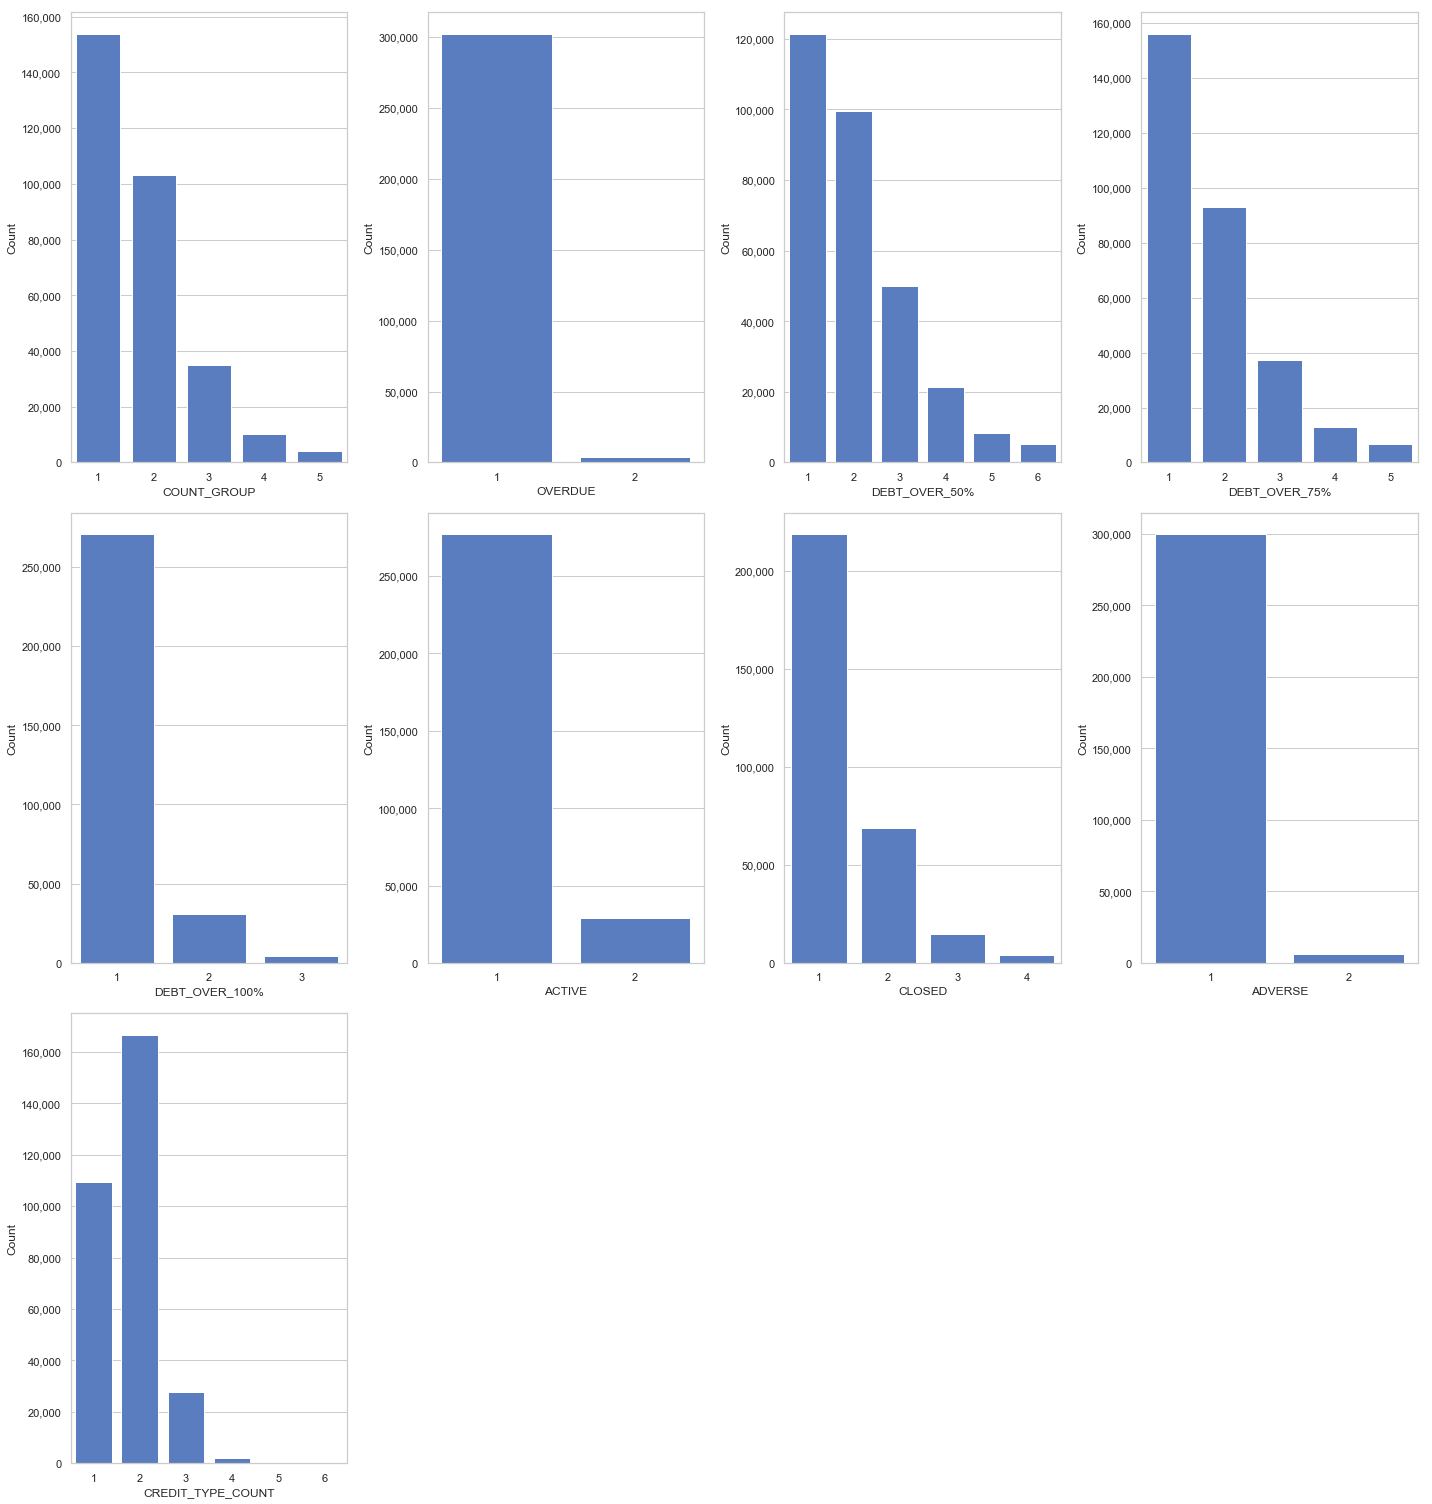

In [118]:
utils.plot_bar(abt_final.int_features,final_dataset)

### 4.9 Save Final Dataset

In [119]:
# rename columns  append all fields with 'BUREAU_' except id field

col_name = []
for c in final_dataset.columns:
    if c =='SK_ID_CURR':
        col_name.append(c)
    else:
        col_name.append("BUREAU_"+c)

final_dataset.columns = col_name

In [120]:
final_dataset.to_csv('data_pre_processed/1_4_bureau.csv',index=False)
print("File was saved.")

File was saved.
